In [4]:
import re
import os
import csv
import numpy as np
import pandas as pd
from itertools import chain
from scipy.stats import linregress,gaussian_kde
import corner

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]

% matplotlib inline

import sys
if sys.platform=='darwin':
    top_path='/Users/codydirks/PGCC/'
else:
    top_path='/DataDisk/datafiles/PGCC_HST/'

x1d_dir=top_path+'x1d_files/'

c=300000.

class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        if len(dat)==10:
            self.ion=dat[0]
            self.n=float(dat[1])
            self.b=float(dat[2])
            self.wav=float(dat[3])
            self.v=float(dat[4])
            self.n_flag=int(dat[5])
            self.b_flag=int(dat[6])
            self.v_flag=int(dat[7])
            self.eqw=float(dat[8])
            self.tot_eqw=float(dat[9])
        elif len(dat)<10:
            self.ion=dat_line[0:10]
            self.n=float(dat_line[10:20])
            self.b=float(dat_line[20:28])
            self.wav=float(dat_line[28:38])
            self.v=float(dat_line[38:48])
            self.n_flag=int(dat_line[48:52])
            self.b_flag=int(dat_line[52:54])
            self.v_flag=int(dat_line[54:56])
            self.eqw=float(dat_line[56:64])
            self.tot_eqw=float(dat_line[64:])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

def load_results(filename):
    gaia_filenames=[top_path+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gaia_entry=fits.open(gaia_filenames[fl])[1].data[idx]
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data


def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))



def parse_results_file(filename):
    ids=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
    ions=[]
    with open(filename) as myfile:
        lines=[x.strip() for x in myfile.readlines()]
        for i in range(len(lines)):
            if len(lines[i].strip())>0:
                dat=lines[i].split()
                if any([dat[0]==x for x in ids]) or dat[0].startswith('CO_'):
                    ions.append(LineInfo(lines[i],lines[i+1]))
    return ions

def get_sightline_fits6p_results(sightline, ion):
    del_v_tol=1.5
    data=[]
    fits6p_prefix=get_fits6p_ion(ion)
    for fl in [x for x in os.listdir(x1d_dir+sightline+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
        ions=parse_results_file(x1d_dir+sightline+'/E140H/'+fl)
        if 'CO' in ion:
            selected_ions=[i for i in ions if i.ion.startswith(ion)]
        else:
            selected_ions=[i for i in ions if i.ion==ion]
        data.append((fl,selected_ions))
    return data

def get_fits6p_ion(strng):
    return strng.strip('*').replace('_','').lower().replace('i','I').replace('nI','ni').strip(']')

def get_table_ion(strng):
    return strng.replace('_I]','').replace('_II','').replace('_I','')



def get_atomic_entry(wav):
    if wav==1328.833:
        wav=1328.8333
    with open('/Users/codydirks/fits6p/atomic.dat','r') as myfile:
        lines=myfile.read().split('\n')[1:]
    for line in lines:
        if float(line.split()[0])==wav:
            return float(line[30:39])

def get_ul(sl,line):
    f=get_atomic_entry(line)
    fil=x1d_dir+sl+'/E140H/'+sl+'_'+str(line)+'.dat'
    wavs=[]
    flxs=[]
    with open(fil,'r') as myfile:
        for entry in myfile:
            wav,flx=entry.split()[:2]
            wavs.append(float(wav))
            flxs.append(float(flx))
            
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    flxcut=np.copy(flxs)
    n=0
    ind=np.array([])
    while abs(np.mean(flxcut)-1)>0.002:
        n=n+1
        ind = np.argpartition(abs(flxs-np.mean(flxcut)), -n)[-n:]
        flxcut=np.delete(flxs,ind)
    tau=np.log10(1/(1-5.*np.std(flxcut)))
    ul=3.768E14*tau/(f*line)
    return np.log10(ul)

In [2]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    
filename='sightline_pgcc_gaia_results.txt'
all_data=load_results(filename)
all_data.sort(key=lambda x: (x[0][0],int(re.search(r'\d+',x[0]).group())))

primary_sample=[x for x in all_data if x[0] in primary_sightlines]
len(primary_sample)

22

In [5]:
del_v_tol=1.5
ion_list=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
ns_dict={}
info={'Sightline':[],'R_dist':[],'Velocity':[]}
for ion in ion_list:
    ns_dict[ion]=0
    
    info[get_table_ion(ion)]=[]
    info[get_table_ion(ion)+'_err']=[]
    
all_data=pd.DataFrame(info)

for sl in primary_sample:
    info['Sightline']=sl[0]
    ra,dec=sl[1]
    galcoords=SkyCoord(ra=ra,dec=dec).galactic
    pgcc=sl[2]
    info['R_dist']=round(get_r_dist(pgcc,ra.value,dec.value),2)
    
    data_dict={}
    for ion in ion_list:
        data_dict[ion]=get_sightline_fits6p_results(info['Sightline'],ion)
    
    vel_comps=[]
    [vel_comps.append(v) for v in [y.v for y in chain(*[x[1] for x in (data_dict['CO']+data_dict['13CO']+data_dict['O_I]']+data_dict['Cl_I'])])]
     if any([abs(v-z)<del_v_tol for z in vel_comps])==False]
        
    vel_comps.sort()
    for v in vel_comps:
        n_dict={}
        comps_dict={}
        # Initialize components and columns to zero
        for ion in ion_list:
            n_dict[ion]=0
            n_dict[ion+'_err']=0
            comps_dict={}
        
        # Iterate over ions and get nearest component, then add columns in that component
        for ion in ion_list:
            for entry in data_dict[ion]:
                comps_dict[ion]=[c for c in entry[1] if abs(c.v-v)<del_v_tol]
                if len(comps_dict[ion])>0:
                    n_tot=sum([x.n for x in comps_dict[ion]])
                    n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    n_dict[ion]=round(np.log10(n_tot),3)
                    #n_dict[ion+'_err']=0.434*n_err/n_tot
                    n_dict[ion+'_err']=round(np.log10(n_err),3)
                    break
                else:
                    fits6p_prefix=get_fits6p_ion(ion)
                    for fl in [x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
                        lam=fl.split('_')[1]
                        dat_file=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith(sl[0]) and x.endswith('.dat') and lam in x][0]
                        lin=dat_file.split('_')[1][:-4]
                        n_dict[ion+'_err']=get_ul(sl[0],float(lin))
                    break
                    
            info[get_table_ion(ion)]=n_dict[ion]
            info[get_table_ion(ion)+'_err']=n_dict[ion+'_err']
        info['Velocity']=v
        new_row=pd.DataFrame({key:[info[key]] for key in info})
        all_data=pd.concat([all_data,new_row])

cols=['Sightline','R_dist','Velocity']+list(chain.from_iterable([[get_table_ion(i),get_table_ion(i)+'_err'] for i in ion_list]))
all_data=all_data[cols].reset_index(drop=True)
all_data=all_data.replace(-np.inf,0)

all_data['H_tot']=np.where(all_data['O']>0,np.log10((10**6/305.)*10**(all_data['O'])),0).round(3)
all_data['H_2']=np.where(all_data['Cl']>0, ((all_data['Cl']+3.7)/0.87),0.).round(3)
all_data['f_H2']=np.where((all_data['H_tot']>0) & (all_data['H_2']>0),10**(np.log10(2.)+all_data['H_2']-all_data['H_tot']),0.0).round(3)
all_data['CO/H2']=np.where((all_data['H_2']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['H_2']),0.0)
all_data['12CO/13CO']=np.where((all_data['13CO']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['13CO']),0.0).round(3)

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
# Compiles the Jenkins f1,f2 data
jenkins_f1=[]
jenkins_f2=[]
with open('jenkins_c_table.txt','r') as myfile:
    for line in myfile:
        if line.startswith('#')==False:
            jenkins_f1.append(float(line.strip().split()[2]))
            jenkins_f2.append(float(line.strip().split()[4]))
jenkins_f1=np.array(jenkins_f1)
jenkins_f2=np.array(jenkins_f2)

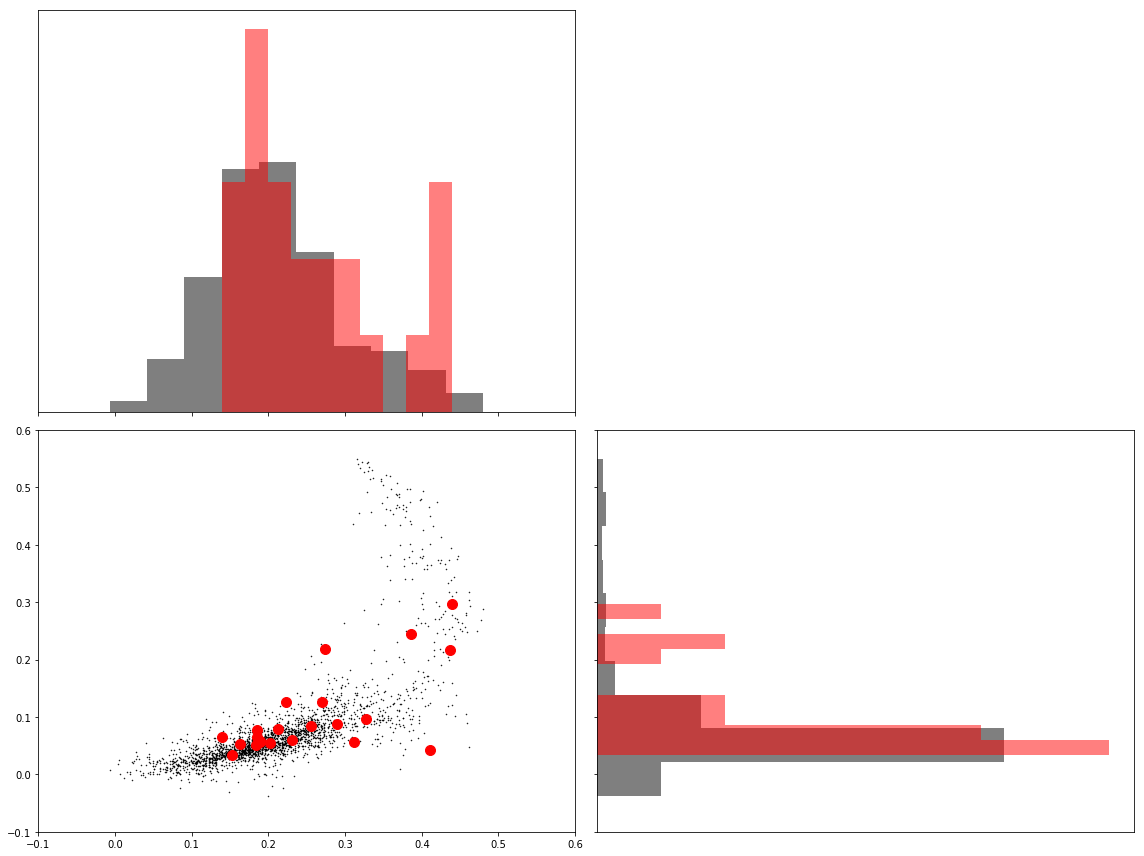

In [17]:
gs=gridspec.GridSpec(2,2)
fig=plt.figure(1,figsize=(16,12))
subplt1=plt.subplot(gs[0])
subplt2=plt.subplot(gs[2])
subplt3=plt.subplot(gs[3])
subplts=[subplt1,subplt2,subplt3]
norm=Normalize(vmin=12,vmax=17)
x = jenkins_f1
y = jenkins_f2
xmin, xmax = -0.1, 0.6
ymin, ymax = -0.1, 0.6

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#subplt2.contour(xx, yy, f, 100,cmap='viridis',alpha=0.2,zorder=1)
subplt2.plot(x,y,'ko',markersize=0.5,zorder=1)
subplt2.set_xlim(xmin,xmax)
subplt2.set_ylim(ymin,ymax)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    
#for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    f1=(10**row['C*'])/Ctot
    f2=(10**row['C**'])/Ctot
    f1s.append(f1)
    f2s.append(f2)
    sc=subplt2.scatter(f1,f2,
                   c='r',vmin=11,vmax=16.5,cmap='viridis',marker='o',s=100,zorder=2)
    #subplt2.text((10**row['C*'])/Ctot,(10**row['C**'])/Ctot,row['Sightline'])
    
#inset1=inset_axes(subplt2,width='3%',height='75%',loc=2)
#plt.colorbar(sc,cax=inset1)
    
subplt1.hist(jenkins_f1,bins=10,normed=True,alpha=0.5,color='k')
subplt1.hist(f1s,bins=10,normed=True,alpha=0.5,color='r')
subplt1.set_xlim(xmin,xmax)
subplt1.tick_params(labelbottom='off')
subplt1.get_yaxis().set_visible(False)

subplt3.hist(jenkins_f2,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='k')
subplt3.hist(f2s,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='r')
subplt3.set_ylim(ymin,ymax)
subplt3.tick_params(labelleft='off')
subplt3.get_xaxis().set_visible(False)
plt.tight_layout()
#plt.colorbar(sc)

In [ ]:
cut_data=cut_data.assign(sortval = (10.**cut_data['C*'])/(10.**cut_data['C']+10.**cut_data['C*']+10.**cut_data['C**'])).sort_values('sortval').drop('sortval', 1)
#for idx,row in cut_data.iterrows():
#    print '{:>9}'.format(row['Sightline']),round(row['C'],3),round(row['C_err'],3),round((10.**row['C*'])/(10.**row['C']+10.**row['C*']+10.**row['C**']),4)
    
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.plot((10.**cut_data['C*'])/(10.**cut_data['C']+10.**cut_data['C*']+10.**cut_data['C**']),
            cut_data['C'],'ko')

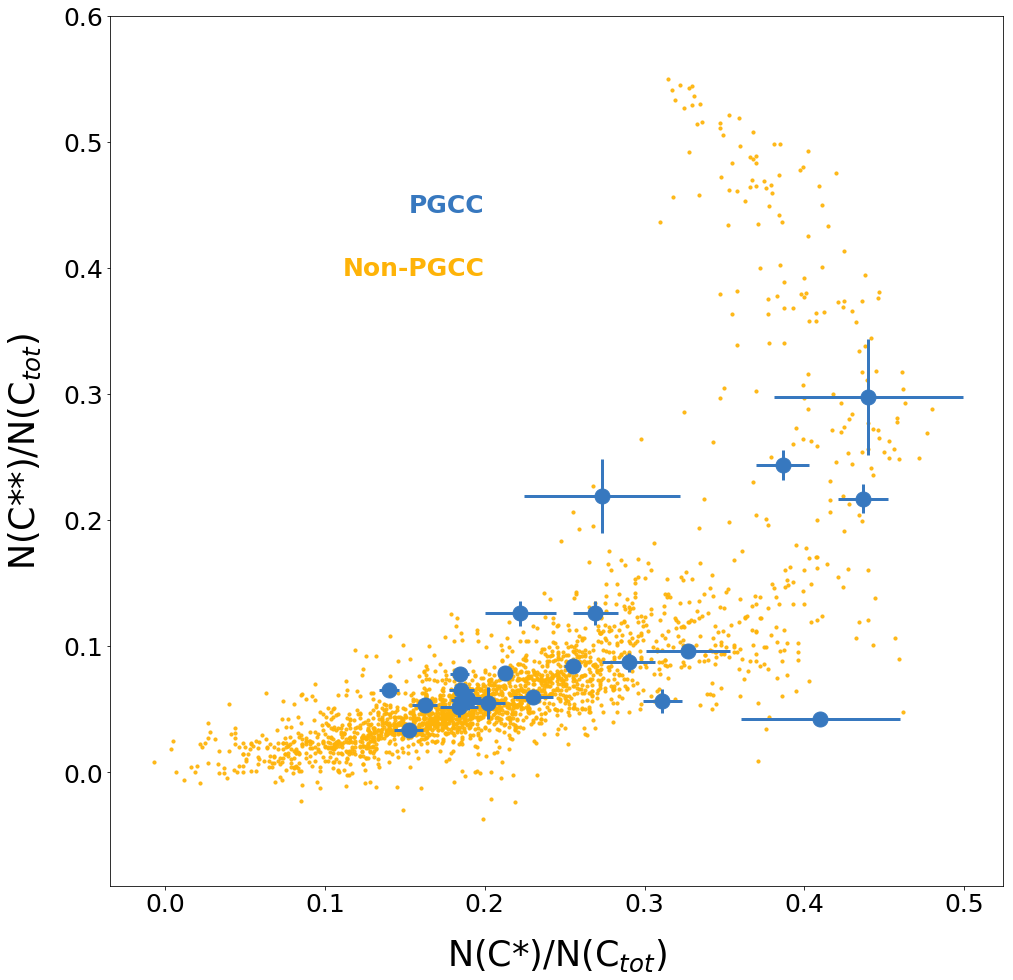

In [18]:
fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)

xmin, xmax = -0.1, 0.53
ymin, ymax = -0.1, 0.6
#subplt.set_xlim(0.2*xmin,xmax)
subplt.set_ylim(0.9*ymin,ymax)

x = jenkins_f1
y = jenkins_f2
subplt.scatter(x,y,marker='o',color=amber,alpha=0.9,s=10,zorder=1)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    
#for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    del_Ctot=np.sqrt(np.sum([10**(row[c+'_err']) for c in ('C','C*','C**')]))
    f1=(10**row['C*'])/Ctot
    del_f1=f1*np.sqrt((10**(row['C*_err']-row['C*']))**2+(del_Ctot/Ctot)**2)
    f2=(10**row['C**'])/Ctot
    del_f2=f2*np.sqrt((10**(row['C**_err']-row['C**']))**2+(del_Ctot/Ctot)**2)
    f1s.append(f1)
    f2s.append(f2)
    subplt.errorbar(f1,f2,xerr=del_f1,yerr=del_f2,marker='o',color=blue,ms=15,zorder=2,elinewidth=3)
    #subplt.text(f1,f2,sl[0])
    
    # Plots other CO rows along sightlines
    if len(sl[1].sort_values('CO',ascending=False)) > 1:
        extra_rows=sl[1].sort_values('CO',ascending=False).iloc[1:]
        for idx,row in extra_rows.iterrows():
            Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
            f1=(10**row['C*'])/Ctot
            f2=(10**row['C**'])/Ctot
            f1s.append(f1)
            f2s.append(f2)
            #sc=subplt.scatter(f1,f2,
            #       c=blue,vmin=11,vmax=16.5,cmap='viridis',marker='o',s=200,zorder=1)
        
# 
for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    f1=(10**row['C*'])/Ctot
    f2=(10**row['C**'])/Ctot
    f1s.append(f1)
    f2s.append(f2)
    if row['CO']>0:
        color=blue
    else:
        color='r'
    #sc=subplt.scatter(f1,f2,
    #            c=color,vmin=11,vmax=16.5,cmap='viridis',marker='o',s=200,zorder=2)
    
    
subplt.tick_params(axis='both', which='major', labelsize=25)
subplt.set_ylabel('N(C**)/N(C$_{tot}$)',fontsize=35,labelpad=20)
subplt.set_xlabel('N(C*)/N(C$_{tot}$)',fontsize=35,labelpad=20)

subplt.text(0.2,0.45,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
subplt.text(0.2,0.4,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)

plt.savefig('/Users/codydirks/Dropbox/Thesis/Thesis/figures/carbon_pressures.png')

In [ ]:
all_data[all_data['Sightline']=='HD13841']